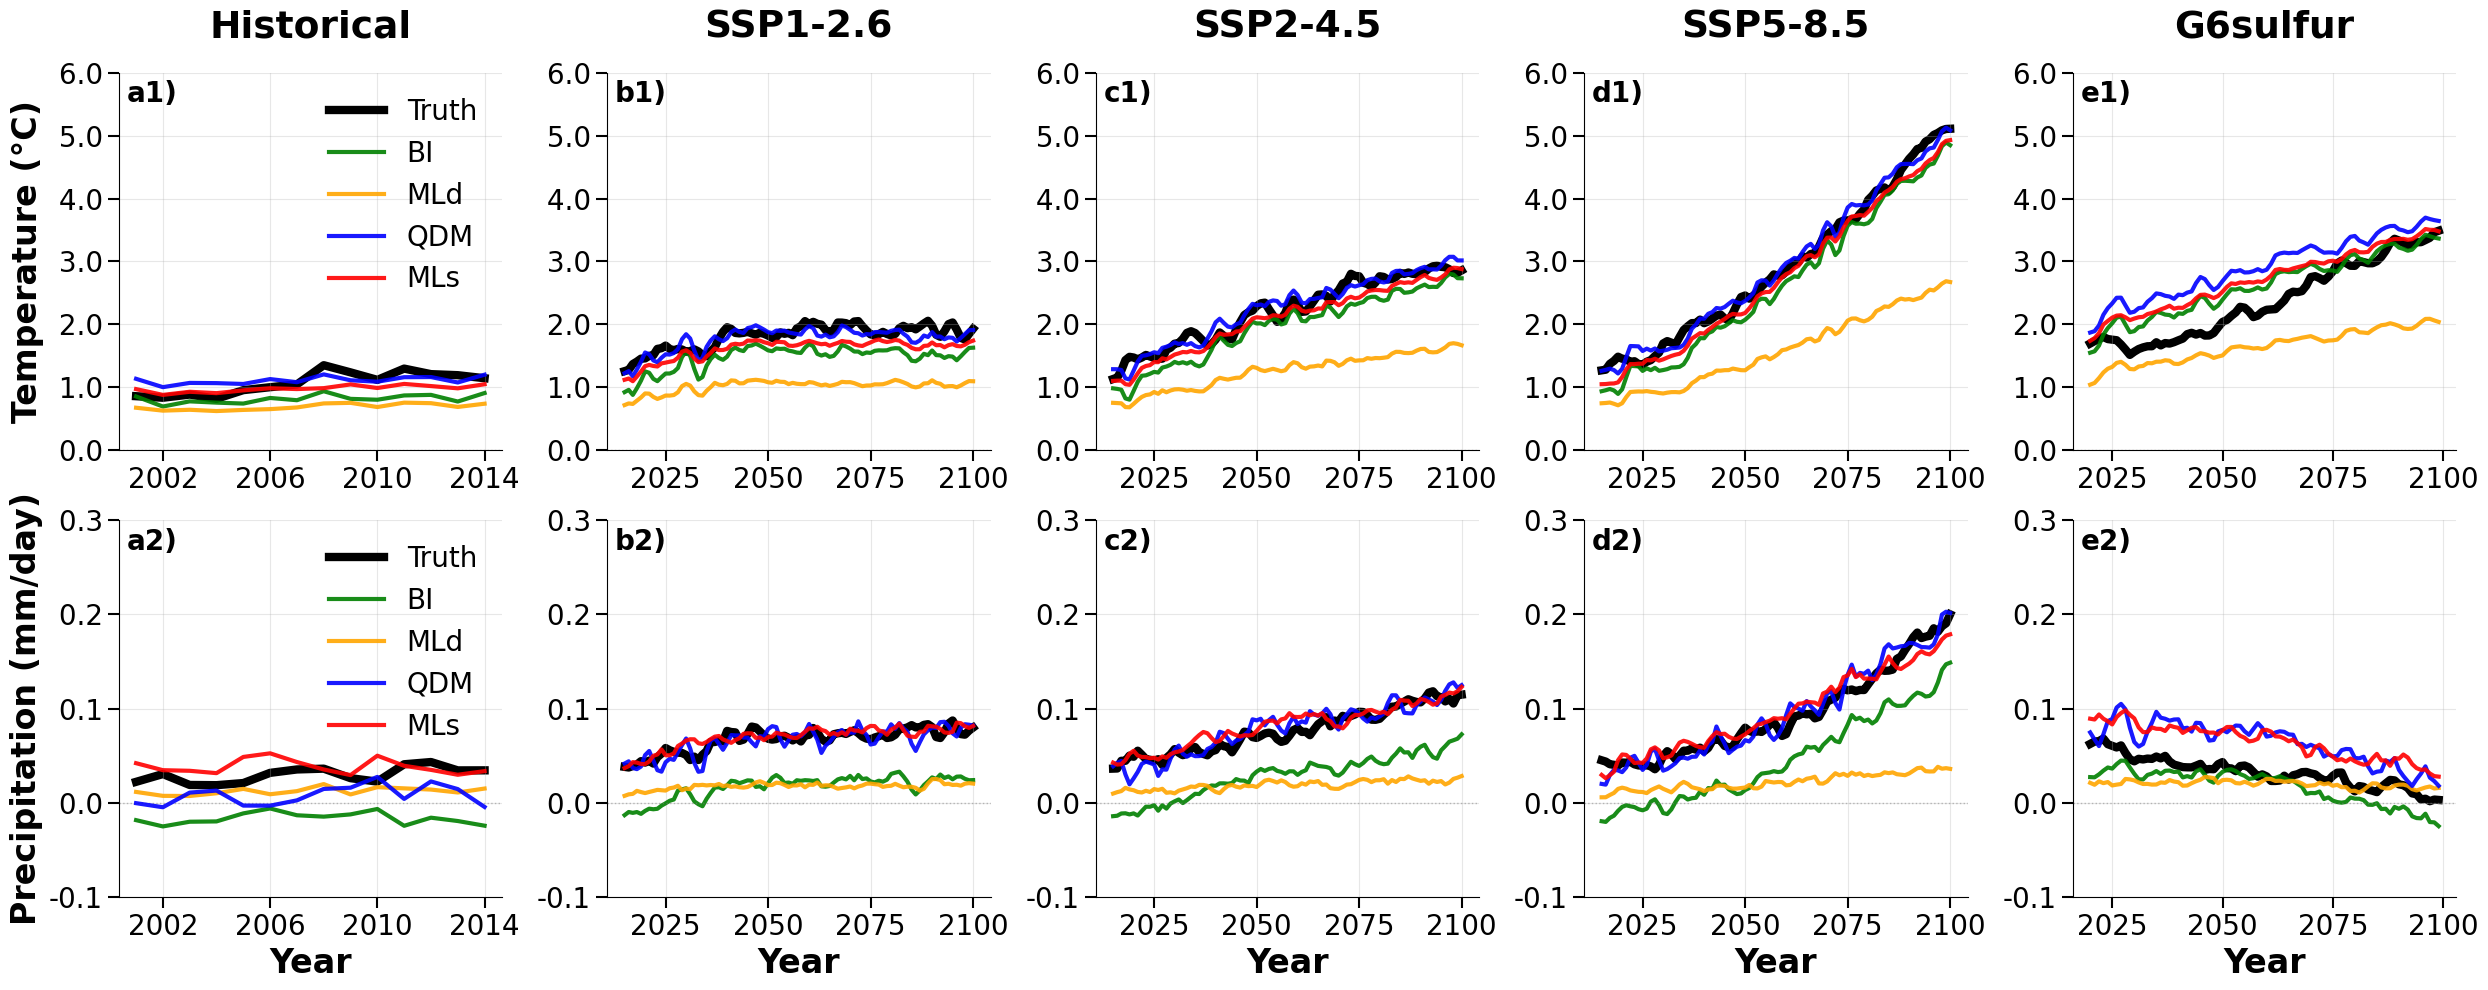

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import pandas as pd

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Load original datasets for baseline calculation
data_dir = Path("../data")
ds_hist_orig = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")

# Scenarios
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur']
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'g6sulfur': 'G6sulfur',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Variables configuration
variables = ['tas', 'pr']
var_config = {
    'tas': {
        'label': 'Temperature (°C)',
        'ylim': (0.0, 6.0),
        'ytick': 1.0
    },
    'pr': {
        'label': 'Precipitation (mm/day)',
        'ylim': (-0.1, 0.3),
        'ytick': 0.1
    }
}

# Model names and colors
model_labels = {
    'groundtruth': 'Truth',
    'bilinear': 'BI',
    'qdm': 'QDM',
    'mld': 'MLd',
    'mls': 'MLs'
}

model_colors = {
    'groundtruth': 'black',
    'bilinear': 'green',
    'qdm': 'blue',
    'mld': 'orange',
    'mls': 'red'
}

def calc_baseline(ds, var, start_year=1850, end_year=1900):
    """Calculate baseline mean for reference period"""
    var_hr = f"{var}_hr"
    data = ds[var_hr]
    years = ds.time.dt.year
    mask = (years >= start_year) & (years <= end_year)
    baseline_data = data.isel(time=mask)
    baseline = baseline_data.mean(dim=['time', 'lat', 'lon'])
    return float(baseline.values)

def calc_global_mean(data):
    """Calculate simple global mean"""
    return np.mean(data, axis=(1, 2))

def to_annual_mean(data, time_coords):
    """Convert to annual averages"""
    years = time_coords.dt.year.values
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean to annual data"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Calculate baselines for both variables
baselines = {var: calc_baseline(ds_hist_orig, var, 1850, 1900) for var in variables}

# Create 2x5 figure
fig, axes = plt.subplots(2, 5, figsize=(25, 10))

# Panel labels
panel_labels = [
    ['a1)', 'b1)', 'c1)', 'd1)', 'e1)'],  # Row 1: tas
    ['a2)', 'b2)', 'c2)', 'd2)', 'e2)']   # Row 2: pr
]

for row, var in enumerate(variables):
    baseline_mean = baselines[var]
    config = var_config[var]
    
    for col, scenario in enumerate(scenarios):
        ax = axes[row, col]
        
        # Determine time slice and smoothing window based on scenario
        if scenario == 'historical':
            time_slice = slice('2001', '2014')
            smooth_window = 1  # No smoothing for historical
        elif scenario == 'g6sulfur':
            time_slice = slice('2020', '2099')
            smooth_window = 3
        else:
            time_slice = slice('2015', '2100')
            smooth_window = 3
        
        # Load main results
        main_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        
        if main_file.exists():
            ds_main = xr.open_dataset(main_file)
            gt_data = ds_main['groundtruth'].sel(time=time_slice).values
            time_coords = ds_main['groundtruth'].sel(time=time_slice).time
            
            # Ground truth
            gt_mean = calc_global_mean(gt_data) - baseline_mean
            years_gt, gt_mean_annual = to_annual_mean(gt_mean, time_coords)
            gt_mean_smooth = smooth_data(gt_mean_annual, window=smooth_window)
            
            ax.plot(years_gt, gt_mean_smooth, 
                   color=model_colors['groundtruth'],
                   linestyle='-',
                   linewidth=6,
                   label=model_labels['groundtruth'], zorder=1)
            
            # Bilinear
            if 'input' in ds_main:
                input_data = ds_main['input'].sel(time=time_slice).values
                input_mean = calc_global_mean(input_data) - baseline_mean
                years_input, input_mean_annual = to_annual_mean(input_mean, time_coords)
                input_mean_smooth = smooth_data(input_mean_annual, window=smooth_window)
                
                ax.plot(years_input, input_mean_smooth, 
                       color=model_colors['bilinear'],
                       linestyle='-',
                       linewidth=3,
                       label=model_labels['bilinear'], alpha=0.9, zorder=2)
            
            # MLd
            if 'pred_zscore_pixel' in ds_main:
                pred_data = ds_main['pred_zscore_pixel'].sel(time=time_slice).values
                pred_mean = calc_global_mean(pred_data) - baseline_mean
                years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
                pred_mean_smooth = smooth_data(pred_mean_annual, window=smooth_window)
                
                ax.plot(years_pred, pred_mean_smooth, 
                       color=model_colors['mld'],
                       linestyle='-',
                       linewidth=3,
                       label=model_labels['mld'], alpha=0.9, zorder=3)
            
            ds_main.close()
        
        # QDM
        qdm_file = results_dir / f"{var}_evaluation_{scenario}_qdm.nc"
        if qdm_file.exists():
            ds_qdm = xr.open_dataset(qdm_file)
            
            if 'pred_qdm' in ds_qdm:
                pred_data = ds_qdm['pred_qdm'].sel(time=time_slice).values
                pred_mean = calc_global_mean(pred_data) - baseline_mean
                years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
                pred_mean_smooth = smooth_data(pred_mean_annual, window=smooth_window)
                
                ax.plot(years_pred, pred_mean_smooth, 
                       color=model_colors['qdm'],
                       linestyle='-',
                       linewidth=3,
                       label=model_labels['qdm'], alpha=0.9, zorder=4)
            
            ds_qdm.close()
        
        # MLs
        residual_file = results_residual_dir / f"{var}_evaluation_{scenario}.nc"
        if residual_file.exists():
            ds_residual = xr.open_dataset(residual_file)
            
            if 'pred_grid' in ds_residual:
                pred_data = ds_residual['pred_grid'].sel(time=time_slice).values
                pred_mean = calc_global_mean(pred_data) - baseline_mean
                years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
                pred_mean_smooth = smooth_data(pred_mean_annual, window=smooth_window)
                
                ax.plot(years_pred, pred_mean_smooth, 
                       color=model_colors['mls'],
                       linestyle='-',
                       linewidth=3,
                       label=model_labels['mls'], alpha=0.9, zorder=5)
            
            ds_residual.close()
        
        # Format axes
        ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        ax.set_ylim(config['ylim'])
        ax.set_yticks(np.arange(config['ylim'][0], config['ylim'][1] + config['ytick']/2, config['ytick']))
        
        if var == 'tas':
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
            
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:+.1f}'.replace('+', ' ')))
        
        # Set x-axis ticks based on scenario
        if scenario == 'historical':
            ax.set_xticks([2002, 2006, 2010, 2014])
        
        # Panel label
        ax.text(0.02, 0.98, panel_labels[row][col],
               transform=ax.transAxes,
               fontsize=20, fontweight='bold',
               va='top', ha='left')
        
        # Title (only on first row)
        if row == 0:
            ax.set_title(scenario_labels[scenario], fontsize=27, fontweight='bold', pad=25)
        
        # Y-axis label (only on first column)
        if col == 0:
            ax.set_ylabel(config['label'], fontsize=24, fontweight='bold')
        
        # X-axis label (only on last row)
        if row == 1:
            ax.set_xlabel('Year', fontsize=24, fontweight='bold')
        
        # Legend (only on first panel of each row)
        if col == 0:
            ax.legend(loc='best', fontsize=20, frameon=False)
        
        ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=20, length=8, width=1.5)

plt.tight_layout()

output_file = figures_dir / "temporal_evolutions.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()


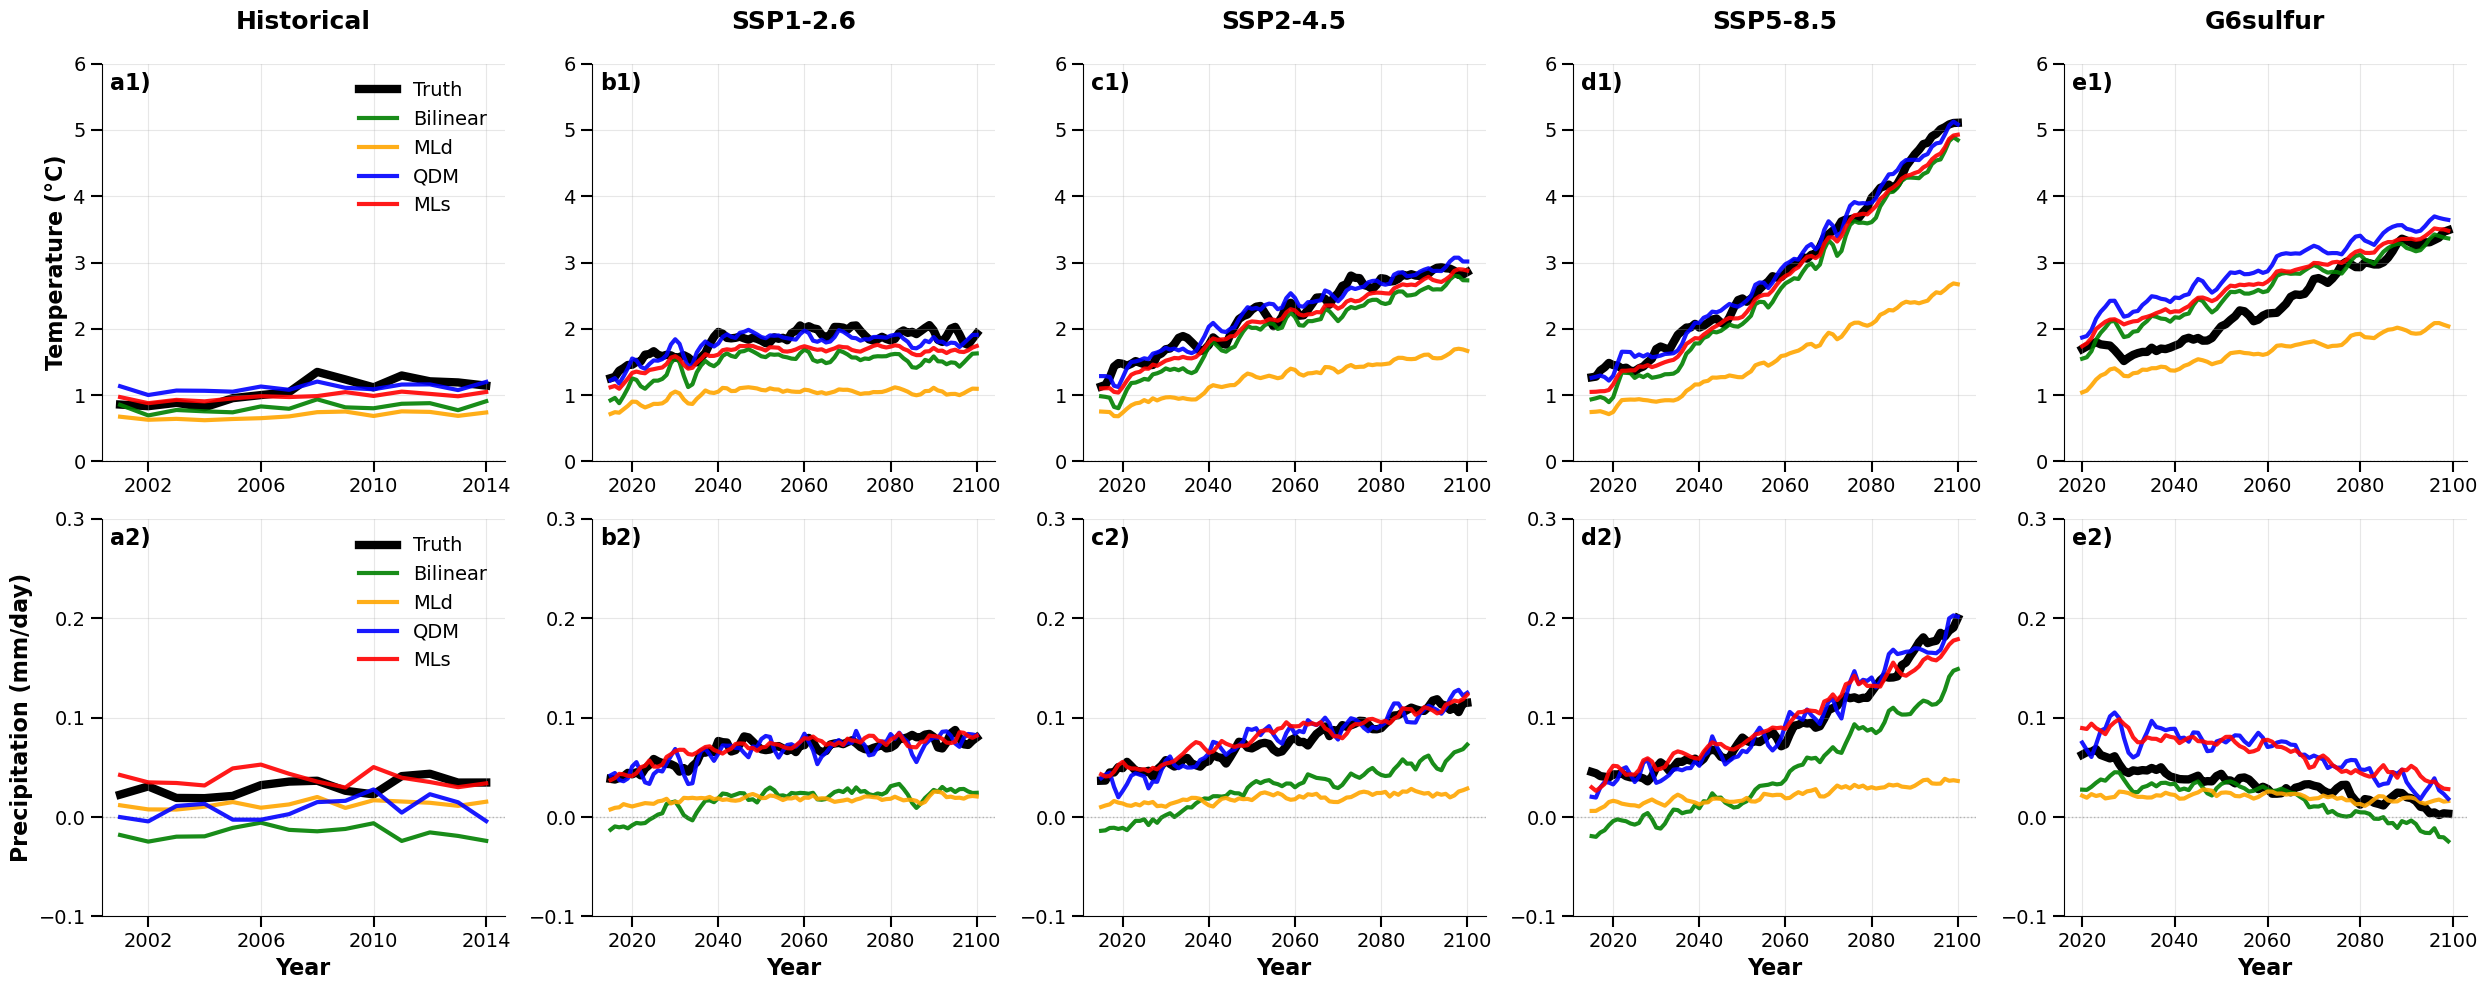

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import pandas as pd

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Load original datasets for baseline calculation
data_dir = Path("../data")
ds_hist_orig = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")

# Scenarios
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur']
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'g6sulfur': 'G6sulfur',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Variables configuration
variables = ['tas', 'pr']
var_config = {
    'tas': {
        'label': 'Temperature (°C)',
        'ylim': (0, 6),
        'ytick': 1
    },
    'pr': {
        'label': 'Precipitation (mm/day)',
        'ylim': (-0.1, 0.3),
        'ytick': 0.1
    }
}

# Model names and colors
model_labels = {
    'groundtruth': 'Truth',
    'bilinear': 'Bilinear',
    'qdm': 'QDM',
    'mld': 'MLd',
    'mls': 'MLs'
}

model_colors = {
    'groundtruth': 'black',
    'bilinear': 'green',
    'qdm': 'blue',
    'mld': 'orange',
    'mls': 'red'
}

def calc_baseline(ds, var, start_year=1850, end_year=1900):
    """Calculate baseline mean for reference period"""
    var_hr = f"{var}_hr"
    data = ds[var_hr]
    years = ds.time.dt.year
    mask = (years >= start_year) & (years <= end_year)
    baseline_data = data.isel(time=mask)
    baseline = baseline_data.mean(dim=['time', 'lat', 'lon'])
    return float(baseline.values)

def calc_global_mean(data):
    """Calculate simple global mean"""
    return np.mean(data, axis=(1, 2))

def to_annual_mean(data, time_coords):
    """Convert to annual averages"""
    years = time_coords.dt.year.values
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean to annual data"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Calculate baselines for both variables
baselines = {var: calc_baseline(ds_hist_orig, var, 1850, 1900) for var in variables}

# Create 2x5 figure
fig, axes = plt.subplots(2, 5, figsize=(25, 10))

# Panel labels
panel_labels = [
    ['a1)', 'b1)', 'c1)', 'd1)', 'e1)'],  # Row 1: tas
    ['a2)', 'b2)', 'c2)', 'd2)', 'e2)']   # Row 2: pr
]

for row, var in enumerate(variables):
    baseline_mean = baselines[var]
    config = var_config[var]
    
    for col, scenario in enumerate(scenarios):
        ax = axes[row, col]
        
        # Determine time slice and smoothing window based on scenario
        if scenario == 'historical':
            time_slice = slice('2001', '2014')
            smooth_window = 1  # No smoothing for historical
        elif scenario == 'g6sulfur':
            time_slice = slice('2020', '2099')
            smooth_window = 3
        else:
            time_slice = slice('2015', '2100')
            smooth_window = 3
        
        # Load main results
        main_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        
        if main_file.exists():
            ds_main = xr.open_dataset(main_file)
            gt_data = ds_main['groundtruth'].sel(time=time_slice).values
            time_coords = ds_main['groundtruth'].sel(time=time_slice).time
            
            # Ground truth
            gt_mean = calc_global_mean(gt_data) - baseline_mean
            years_gt, gt_mean_annual = to_annual_mean(gt_mean, time_coords)
            gt_mean_smooth = smooth_data(gt_mean_annual, window=smooth_window)
            
            ax.plot(years_gt, gt_mean_smooth, 
                   color=model_colors['groundtruth'],
                   linestyle='-',
                   linewidth=6,
                   label=model_labels['groundtruth'], zorder=1)
            
            # Bilinear
            if 'input' in ds_main:
                input_data = ds_main['input'].sel(time=time_slice).values
                input_mean = calc_global_mean(input_data) - baseline_mean
                years_input, input_mean_annual = to_annual_mean(input_mean, time_coords)
                input_mean_smooth = smooth_data(input_mean_annual, window=smooth_window)
                
                ax.plot(years_input, input_mean_smooth, 
                       color=model_colors['bilinear'],
                       linestyle='-',
                       linewidth=3,
                       label=model_labels['bilinear'], alpha=0.9, zorder=2)
            
            # MLd
            if 'pred_zscore_pixel' in ds_main:
                pred_data = ds_main['pred_zscore_pixel'].sel(time=time_slice).values
                pred_mean = calc_global_mean(pred_data) - baseline_mean
                years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
                pred_mean_smooth = smooth_data(pred_mean_annual, window=smooth_window)
                
                ax.plot(years_pred, pred_mean_smooth, 
                       color=model_colors['mld'],
                       linestyle='-',
                       linewidth=3,
                       label=model_labels['mld'], alpha=0.9, zorder=3)
            
            ds_main.close()
        
        # QDM
        qdm_file = results_dir / f"{var}_evaluation_{scenario}_qdm.nc"
        if qdm_file.exists():
            ds_qdm = xr.open_dataset(qdm_file)
            
            if 'pred_qdm' in ds_qdm:
                pred_data = ds_qdm['pred_qdm'].sel(time=time_slice).values
                pred_mean = calc_global_mean(pred_data) - baseline_mean
                years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
                pred_mean_smooth = smooth_data(pred_mean_annual, window=smooth_window)
                
                ax.plot(years_pred, pred_mean_smooth, 
                       color=model_colors['qdm'],
                       linestyle='-',
                       linewidth=3,
                       label=model_labels['qdm'], alpha=0.9, zorder=4)
            
            ds_qdm.close()
        
        # MLs
        residual_file = results_residual_dir / f"{var}_evaluation_{scenario}.nc"
        if residual_file.exists():
            ds_residual = xr.open_dataset(residual_file)
            
            if 'pred_grid' in ds_residual:
                pred_data = ds_residual['pred_grid'].sel(time=time_slice).values
                pred_mean = calc_global_mean(pred_data) - baseline_mean
                years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
                pred_mean_smooth = smooth_data(pred_mean_annual, window=smooth_window)
                
                ax.plot(years_pred, pred_mean_smooth, 
                       color=model_colors['mls'],
                       linestyle='-',
                       linewidth=3,
                       label=model_labels['mls'], alpha=0.9, zorder=5)
            
            ds_residual.close()
        
        # Format axes
        ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        ax.set_ylim(config['ylim'])
        ax.set_yticks(np.arange(config['ylim'][0], config['ylim'][1] + config['ytick']/2, config['ytick']))
        
        # Set x-axis ticks based on scenario
        if scenario == 'historical':
            ax.set_xticks([2002, 2006, 2010, 2014])
        
        # Panel label
        ax.text(0.02, 0.98, panel_labels[row][col],
               transform=ax.transAxes,
               fontsize=16, fontweight='bold',
               va='top', ha='left')
        
        # Title (only on first row)
        if row == 0:
            ax.set_title(scenario_labels[scenario], fontsize=18, fontweight='bold', pad=25)
        
        # Y-axis label (only on first column)
        if col == 0:
            ax.set_ylabel(config['label'], fontsize=16, fontweight='bold')
        
        # X-axis label (only on last row)
        if row == 1:
            ax.set_xlabel('Year', fontsize=16, fontweight='bold')
        
        # Legend (only on first panel of each row)
        if col == 0:
            ax.legend(loc='best', fontsize=14, frameon=False)
        
        ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=14, length=8, width=1.5)

plt.tight_layout()

output_file = figures_dir / "fig3.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()
